# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v6</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- fit GP to raw data as a smoothing function
- take derivative of smoothed data, which is possible via chain rule of GP analytic gradient
- fit GP to derivative, which is the "GP Model" of TCLab
- integrate GP to validate model of derivative

## Change Log
- This files is derived from `pyomo_tclab_v6.ipynb`

## Setup

In [1]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [2]:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [3]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

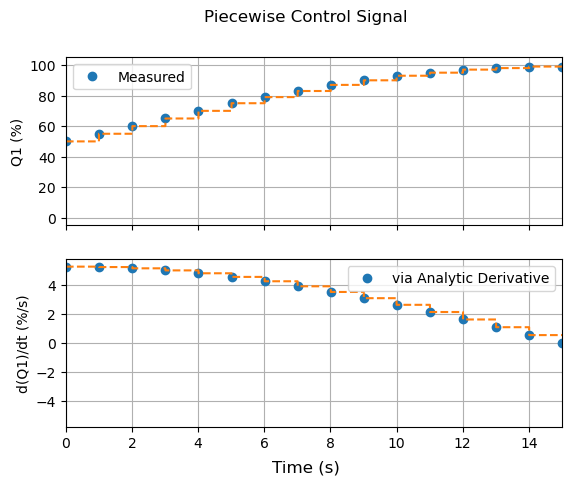

In [4]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [5]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [6]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

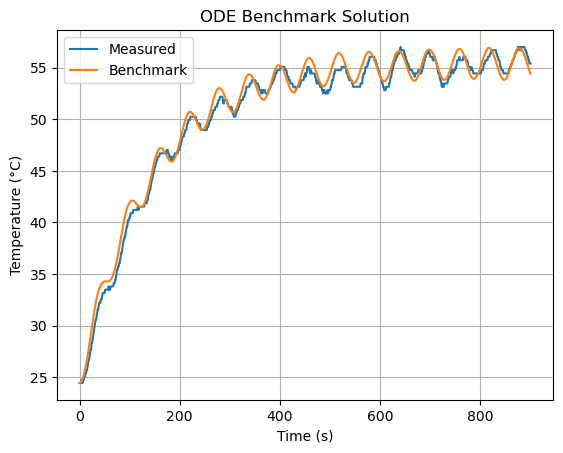

In [7]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a GP as the smoothing function,

In [8]:
GP_T = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP_T.fit([tvec, Q1], TS1, clean=True)

[1, 3592.1272475128376]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705103]
[4, 574.1060402705103]
[4, 540.913851438417]
[4, -331.6235740865496]
[5, -331.6235740865496]
[5, -331.6235740865496]
[5, -384.52968105955193]
[6, -384.52968105955193]
[6, -384.52968105955193]
[6, -391.22681724247286]
[6, -394.68886203696707]
[7, -394.68886203696707]
[7, -394.68886203696707]
[7, -390.73500263956157]


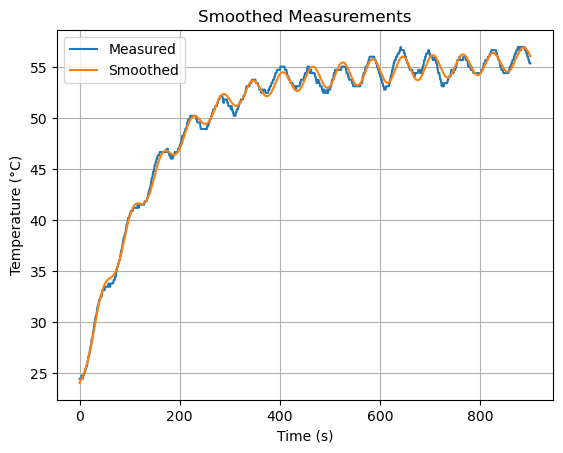

In [9]:
TS1_smooth = GP_T.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_smooth)
plt.grid()
plt.title('Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Smoothed'])

### Derivative

Applying the chain rule to obtain training data,

In [10]:
dGP = GP_T.bss_derivatives()  # gradient of GP_T

dGPdt = interp1d(tvec, dGP[:, 0])
dGPdQ1 = interp1d(Q1, dGP[:, 1])
dTS1f = lambda t: dGPdt(t) + dGPdQ1(Q1f(t)) * dQ1f(t)  # interpolation function

dTS1 = dTS1f(tvec)  # evaluate interpolation function at tvec to form training data

Validating training data:

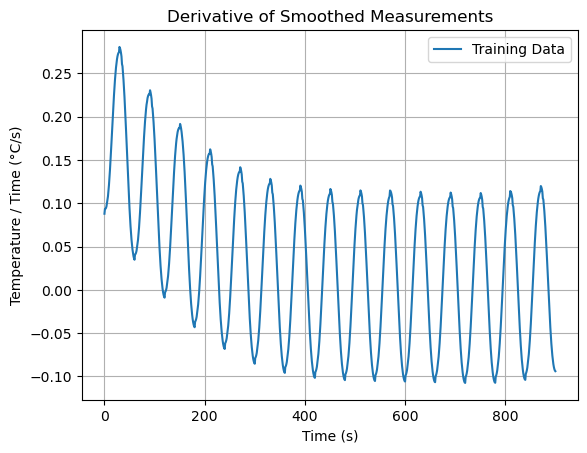

In [11]:
%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.title('Derivative of Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data'])
plt.grid()

In [12]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec)

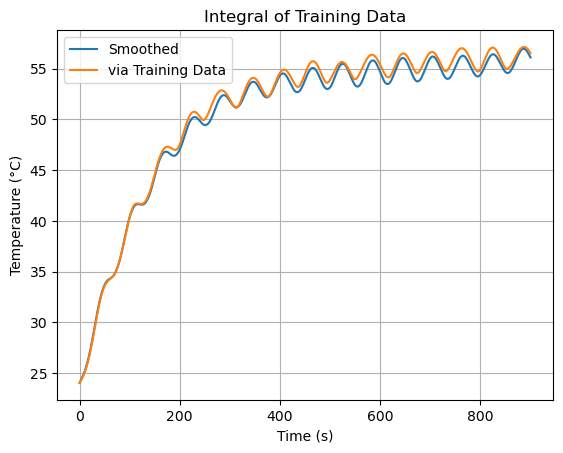

In [13]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

### Optimal Lag Time

In [14]:
GPs_dT = [FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)]
print("Training with no lag:")
GPs_dT[0].fit([TS1, Q1], dTS1, clean=True)

dt = tvec[1] - tvec[0]  # fixed time step
for i in range(1, 9):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)

Training with no lag:
[1, -3650.7125659888316]
[2, -3649.1501836619027]
[2, -3647.8724592231047]
[3, -3645.260638857071]

Training with lag of 1 time steps:
[1, -3645.4118556713483]
[2, -3643.7892609816145]
[2, -3643.9146262940885]
[3, -3642.0947270762117]

Training with lag of 2 time steps:
[1, -3659.734515531957]
[2, -3658.0466201240215]
[2, -3660.0915504531813]
[3, -3659.3363966425004]
[3, -3710.248308639969]
[4, -3715.3536562743957]
[4, -3715.3536562743957]
[4, -3726.1826533974263]
[5, -3741.1649677407604]
[5, -3741.1649677407604]
[5, -3797.0287257806976]
[6, -3797.0287257806976]
[6, -3812.476089480895]
[6, -3816.563566772171]
[6, -3814.565644637287]
[7, -3814.565644637287]
[7, -3818.4560473495694]
[7, -3818.4560473495694]
[7, -3824.132505516958]
[8, -3824.132505516958]
[8, -3824.132505516958]
[8, -3822.639460296302]

Training with lag of 3 time steps:
[1, -3694.1003975179146]
[2, -3694.1003975179146]
[2, -3696.606877203255]
[3, -3696.7580102194215]
[3, -3756.14421031864]
[4, -3760

In [15]:
def _plot_GPs_dT(GPs_dT, dTS1_GPs=[], i0=0):
    %matplotlib inline
    fig, axs = plt.subplots(3, 3)
    fig.suptitle('Derivative of Smoothed Measurements, GP Model')
    fig.supxlabel('Time (s)')
    fig.supylabel('Temperature / Time (°C/s)')

    i = i0 - 1
    for j in range(3):
        for k in range(3):
            i += 1
            dTS1_GPs.append(GPs_dT[i].evaluate())
            
            axs[j, k].plot(tvec, dTS1)
            axs[j, k].plot(tvec[i::], dTS1_GPs[i])
            axs[j, k].set_title(f"Lag = {i} dt")
            axs[j, k].grid()
    fig.tight_layout()

    return dTS1_GPs

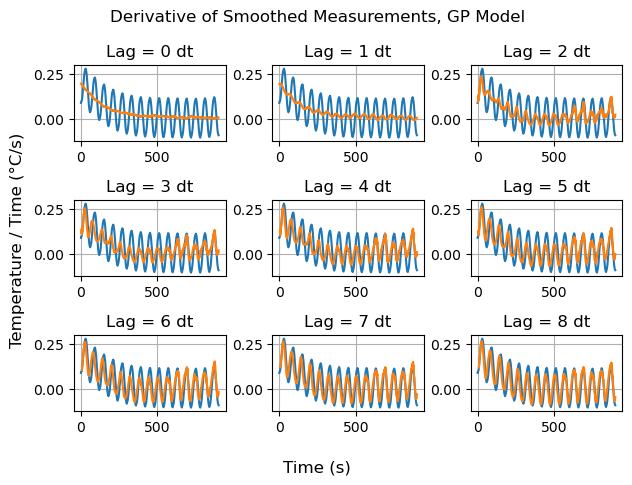

In [16]:
dTS1_GPs = _plot_GPs_dT(GPs_dT)

Repeat:

In [17]:
for i in range(9, 18):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 9 time steps:
[1, -4405.645104801545]
[2, -4405.645104801545]
[2, -4419.27095497086]
[3, -4426.044041396975]
[3, -4556.508083996545]
[4, -4571.971683063677]
[4, -4571.491907619689]
[4, -4613.1956593228]
[5, -4645.354544057974]
[5, -4645.354544057974]
[5, -4707.828651518702]
[6, -4707.828651518702]
[6, -4718.675237536215]
[6, -4718.269151291678]
[6, -4727.734134761995]
[7, -4727.734134761995]
[7, -4727.964813945358]
[7, -4727.964813945358]
[7, -4726.348117678763]
[8, -4726.348117678763]

Training with lag of 10 time steps:
[1, -4645.018710535752]
[2, -4645.018710535752]
[2, -4659.312930617306]
[3, -4665.124973683735]
[3, -4806.639761668912]
[4, -4823.400806941955]
[4, -4823.400806941955]
[4, -4871.066900448048]
[5, -4905.763102891157]
[5, -4905.763102891157]
[5, -4971.428396391698]
[6, -4971.428396391698]
[6, -4980.181452297143]
[6, -4979.483778564696]
[6, -4990.649580247344]
[7, -4990.649580247344]
[7, -4990.253923897493]
[7, -4990.253923897493]

Training with lag

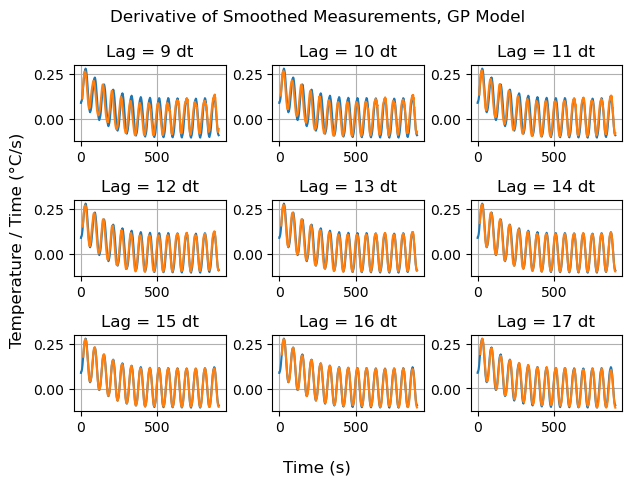

In [18]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 9)

Repeat:

In [19]:
for i in range(18, 27):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 18 time steps:
[1, -6006.621752429165]
[2, -6006.180001138726]
[2, -6045.168794462985]
[3, -6051.297626708921]
[3, -6069.404589934874]
[4, -6077.79518398729]
[4, -6078.148103224358]
[4, -6077.312865270385]
[5, -6101.818654238974]
[5, -6105.875516340196]
[5, -6121.552316083276]
[6, -6121.552316083276]
[6, -6123.042838953578]
[6, -6123.042838953578]
[6, -6127.639383651268]
[7, -6127.639383651268]
[7, -6140.291399739792]
[7, -6142.644324253421]
[7, -6148.893389278879]
[8, -6148.893389278879]
[8, -6148.893389278879]
[8, -6148.932236758245]
[8, -6150.549388994481]
[8, -6166.331939853361]
[9, -6166.331939853361]
[9, -6166.331939853361]
[9, -6170.500191534999]
[9, -6184.479305326363]
[9, -6220.126568189371]
[10, -6220.126568189371]
[10, -6220.126568189371]
[10, -6220.126568189371]

Training with lag of 19 time steps:
[1, -5429.4831524726615]
[2, -5428.354569208855]
[2, -5457.343077207972]
[3, -5463.1631382751875]
[3, -5489.563699124295]
[4, -5498.008689321788]
[4, -5498.

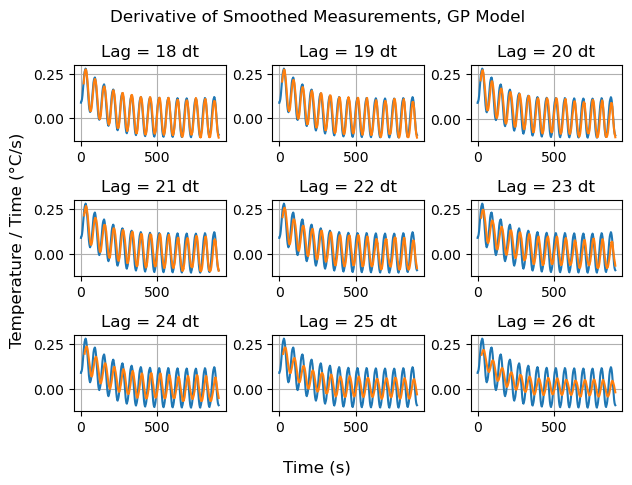

In [20]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 18)

Repeat:

In [21]:
for i in range(27, 36):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 27 time steps:
[1, -3664.112753386734]
[2, -3664.112753386734]
[2, -3662.458668068968]
[3, -3662.458668068968]

Training with lag of 28 time steps:
[1, -3597.866146581404]
[2, -3597.866146581404]
[2, -3596.777290386751]
[3, -3596.777290386751]

Training with lag of 29 time steps:
[1, -3552.8054368337944]
[2, -3551.1207992588215]
[2, -3552.1499216595867]
[3, -3552.1499216595867]

Training with lag of 30 time steps:
[1, -3527.854353597124]
[2, -3526.2869873764284]
[2, -3530.557341395819]
[3, -3530.557341395819]
[3, -3542.8097804492936]
[4, -3544.6319070503514]
[4, -3545.3582070909424]
[4, -3597.2576560090547]
[5, -3603.346775488377]
[5, -3603.346775488377]
[5, -3601.367008985316]
[6, -3601.367008985316]

Training with lag of 31 time steps:
[1, -3522.6228697599954]
[2, -3521.1756201857315]
[2, -3529.585484973555]
[3, -3528.2204665486715]
[3, -3550.223843534124]
[4, -3559.130697973469]
[4, -3562.321135944757]
[4, -3620.943856021635]
[5, -3629.668655588648]
[5, -3629.6

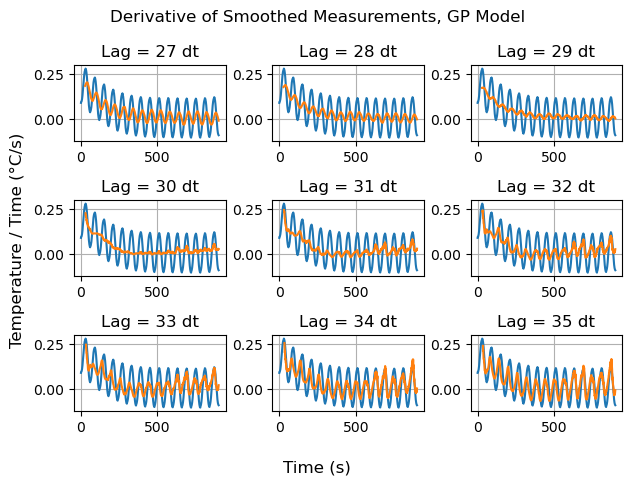

In [22]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 27)

Now that GP models are trained for various lag times, the error of each may be evaluated.

In [23]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

In [24]:
RMSEs = []
for i in range(len(dTS1_GPs)):
    RMSEs.append(_rmse(dTS1[i::], dTS1_GPs[i]))

i_opt = np.argmin(RMSEs)  # optimal lag
print(f"Optimal Lag:\n\n\
       i = {i_opt}\n\
     Lag = i*dt = {i_opt * dt} s\n\
    RMSE = {RMSEs[i_opt]} °C")

Optimal Lag:

       i = 15
     Lag = i*dt = 15.0 s
    RMSE = 0.005072154251987991 °C


Defining GP model as the one trained with the optimal lag:

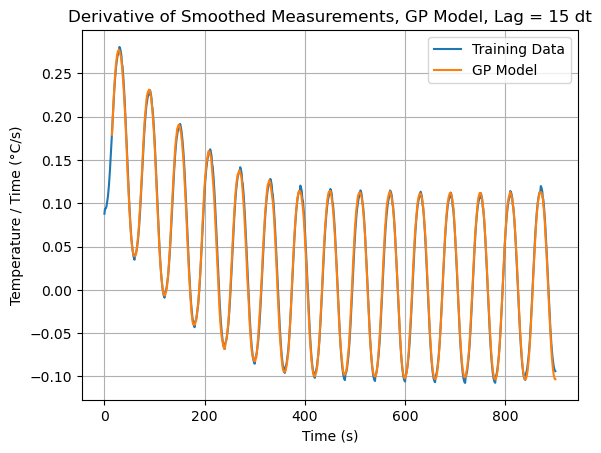

In [25]:
GP_dT = GPs_dT[i_opt]
dTS1_GP = dTS1_GPs[i_opt]  # == GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec[i_opt::], dTS1_GP)
plt.title(f"Derivative of Smoothed Measurements, GP Model, Lag = {i_opt} dt")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

### Integration

In [26]:
def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], Q1f(t - i_opt * dt)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::])

Traceback (most recent call last):
  File "/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    return self.fun_single(t, y)
  File "/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
  File "/var/folders/3w/vr4xmyqs451dg23xk88pqcg00000gq/T/ipykernel_6384/3385637346.py", line 3, in dy_GP
  File "/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py", line 694, in evaluate
    current = _process_kwargs(default | default_for_clean, kwargs)
  File "/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py", line 71, in _process_kwar

: 

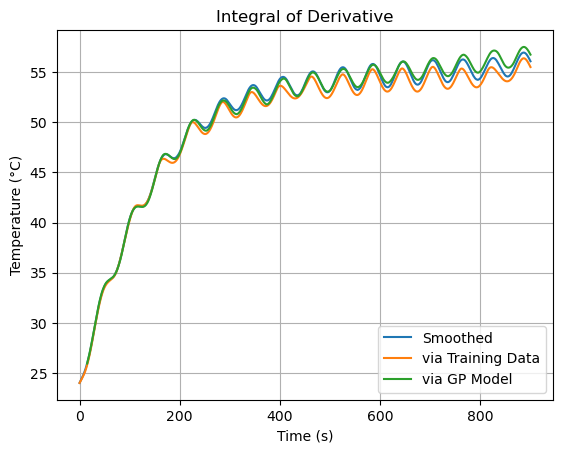

In [ ]:
TS1_dGP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model'])
plt.grid()

Repeat, but with fixed time step:

In [ ]:
soln_GP_fixed_dt = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::], first_step=1, min_step=1, max_step=1)

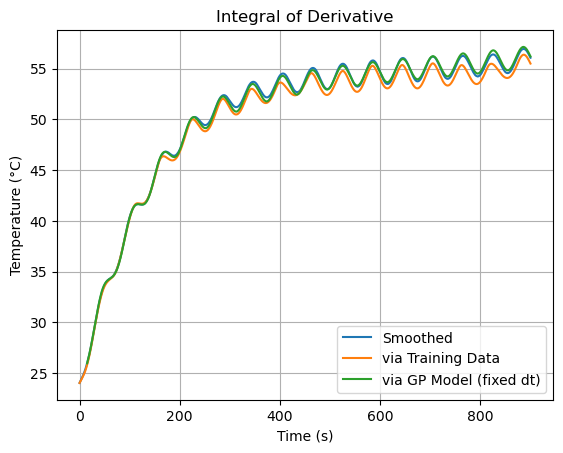

In [ ]:
TS1_dGP_fixed_dt = soln_GP_fixed_dt.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model (fixed dt)'])
plt.grid()

### Comparison of Variable $\Delta t$ vs. Fixed $\Delta t$

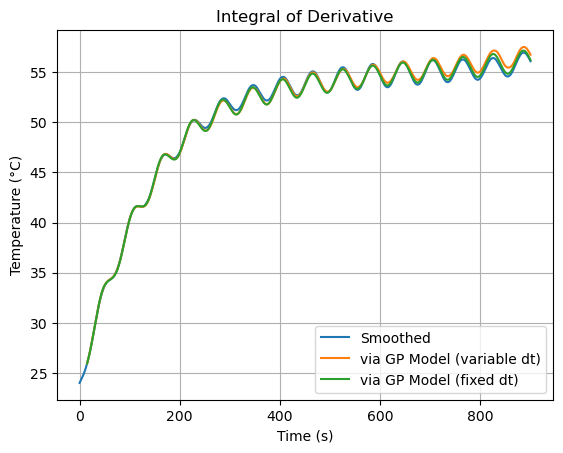

Comparison of Variable dt vs. Fixed dt:

    | Timestep | RMSE (°C) |
    |----------|-----------|
    | Variable | 0.3539508 |
    | Fixed    | 0.2026400 |


In [ ]:
RMSE_dGP = _rmse(TS1_smooth[i_opt::], TS1_dGP)
RMSE_dGP_fixed_dt = _rmse(TS1_smooth[i_opt::], TS1_dGP_fixed_dt)

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model (variable dt)', 'via GP Model (fixed dt)'])
plt.grid()
plt.show()

print(f"Comparison of Variable dt vs. Fixed dt:\n\n\
    | Timestep | RMSE (°C) |\n\
    |----------|-----------|\n\
    | Variable | {"{0:0.7f}".format(round(RMSE_dGP, 7))} |\n\
    | Fixed    | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")

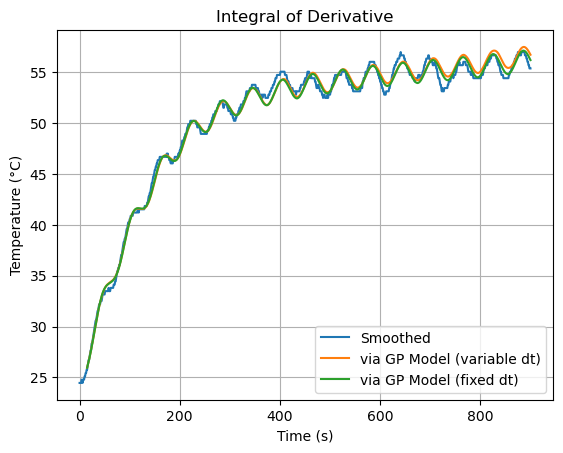

Comparison of Variable dt vs. Fixed dt:

    | Timestep | RMSE (°C) |
    |----------|-----------|
    | Variable | 0.6066471 |
    | Fixed    | 0.4996014 |


In [ ]:
RMSE_dGP_raw = _rmse(TS1[i_opt::], TS1_dGP)
RMSE_dGP_fixed_dt_raw = _rmse(TS1[i_opt::], TS1_dGP_fixed_dt)

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model (variable dt)', 'via GP Model (fixed dt)'])
plt.grid()
plt.show()

print(f"Comparison of Variable dt vs. Fixed dt:\n\n\
    | Timestep | RMSE (°C) |\n\
    |----------|-----------|\n\
    | Variable | {"{0:0.7f}".format(round(RMSE_dGP_raw, 7))} |\n\
    | Fixed    | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt_raw, 7))} |")

## GP Model of Residual

- targets: smoothed data
- predictions: fixed timestep

In [ ]:
res = TS1_smooth[i_opt::] - TS1_dGP_fixed_dt

GP_res = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res.fit(tvec[i_opt::], res, clean=True)

[1, -2277.421315998751]
[2, -2993.622582582231]
[3, -3109.0444881323133]
[4, -3383.591322458731]
[5, -3389.8093534297086]
[6, -3395.967918945472]
[7, -3584.841419507755]
[8, -3592.4513721783132]
[9, -3615.969457315754]
[10, -3628.1364324369033]
[11, -3644.2267782975587]
[12, -3644.2267782975587]
[13, -3644.783610876738]
[14, -3644.783610876738]
[15, -3644.783610876738]
[16, -3644.783610876738]


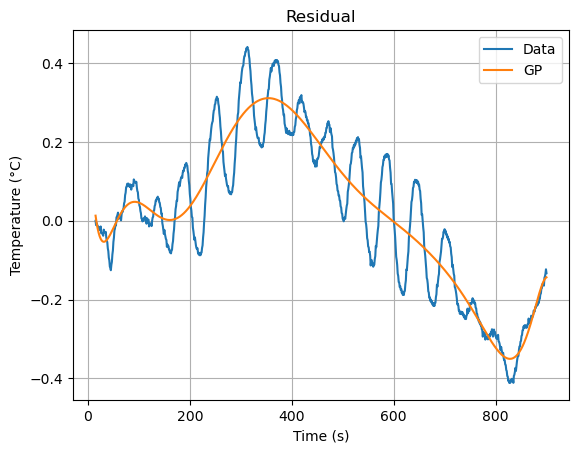

In [ ]:
res_GP = GP_res.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res)
plt.plot(tvec[i_opt::], res_GP)
plt.title('Residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

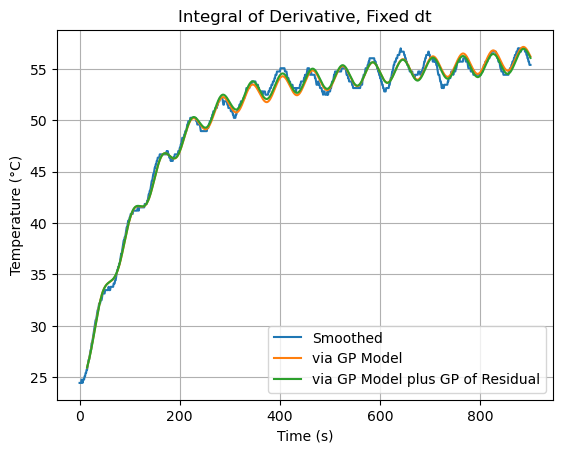

In [ ]:
TS1_dGP_fixed_dt_plus_res = TS1_dGP_fixed_dt + res_GP

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res)
plt.title('Integral of Derivative, Fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

Repeat, but with raw data:

In [ ]:
res_raw = TS1[i_opt::] - TS1_dGP_fixed_dt

GP_res_raw = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res_raw.fit(tvec[i_opt::], res_raw, clean=True)

[1, -388.0479031282921]
[2, -446.3277552950028]
[3, -453.32152175639203]
[4, -458.7126403274733]
[5, -458.7126403274733]
[6, -458.7126403274733]
[7, -458.7126403274733]


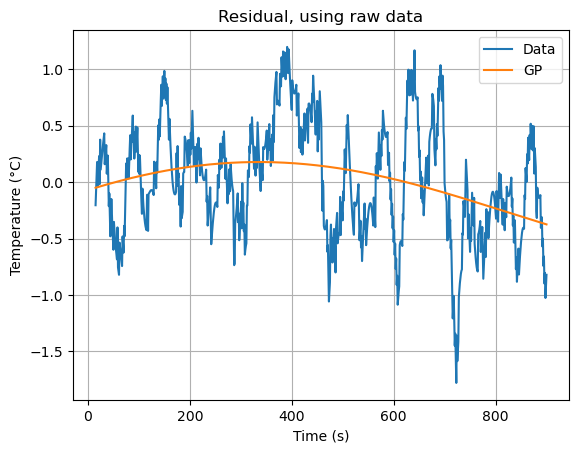

In [ ]:
res_GP_raw = GP_res_raw.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res_raw)
plt.plot(tvec[i_opt::], res_GP_raw)
plt.title('Residual, using raw data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

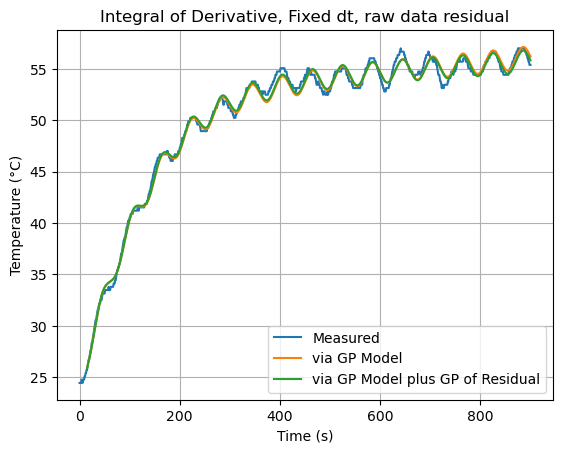

In [ ]:
TS1_dGP_fixed_dt_plus_res_raw = TS1_dGP_fixed_dt + res_GP_raw

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res_raw)
plt.title('Integral of Derivative, Fixed dt, raw data residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

## Benchmark Comparison

Since the residual, modeled only with $t$, does not seem to provide significant improvement, the integrated GP at fixed timestep will be considered the predictions.

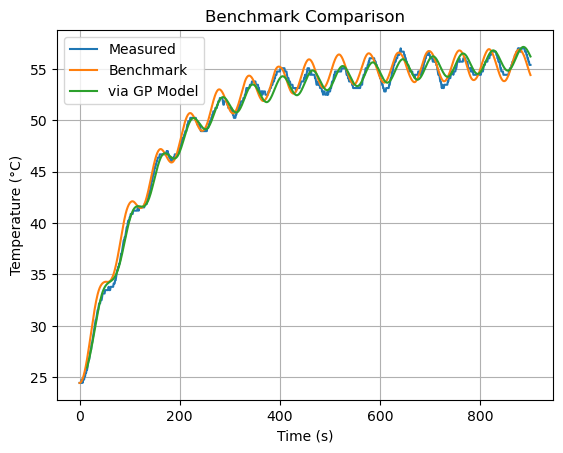

Benchmark Comparison:

    | Method                                 | RMSE (°C) |
    |----------------------------------------|-----------|
    | Benchmark (ODE)                        | 0.8116180 |
    | GP (piecewise Q1, lagged Q1, fixed dt) | 0.2026400 |


In [ ]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
print(f"Benchmark Comparison:\n\n\
    | Method                                 | RMSE (°C) |\n\
    |----------------------------------------|-----------|\n\
    | Benchmark (ODE)                        | {"{0:0.7f}".format(round(RMSE_benchmark, 7))} |\n\
    | GP (piecewise Q1, lagged Q1, fixed dt) | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")